In [16]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import os

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
#View Column Values
measurement.__table__.columns.values()


[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [10]:
station.__table__.columns.values()

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
session.query(measurement.date).count()

19550

In [13]:
session.query(measurement.date).order_by(measurement.date).first()

('2010-01-01')

In [14]:
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23')

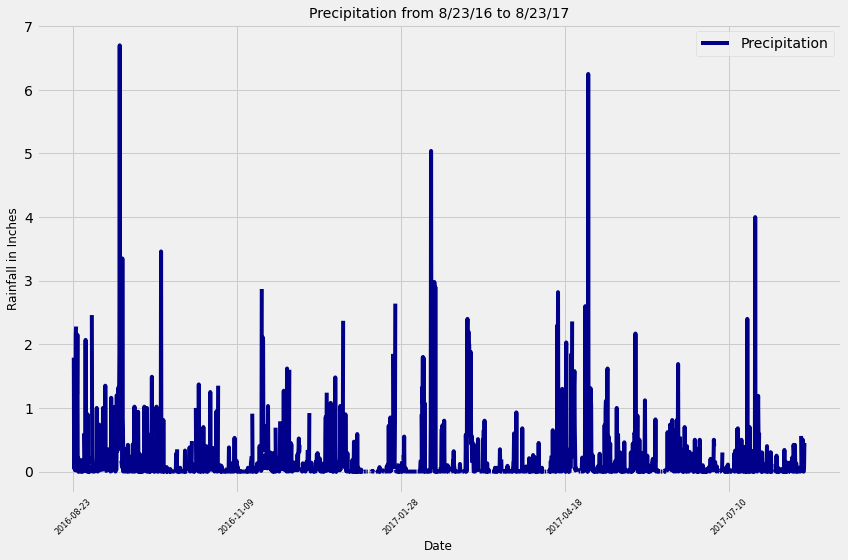

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - relativedelta(months = 12)

# Perform a query to retrieve the data and precipitation scores
year_prcp = session.query(measurement.date, measurement.prcp).filter(measurement.date >= query_date).all()
year_prcp

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(year_prcp)
df = df.set_index('date')


# Sort the dataframe by date
df = df.sort_index()
df.head(25)
# Use Pandas Plotting with Matplotlib to plot the data

df.plot(figsize=(12,8), color="darkblue")
plt.xlabel("Date", size=12)
plt.ylabel ("Rainfall in Inches", size=12)
plt.title("Precipitation from 8/23/16 to 8/23/17", size=14)
plt.legend(["Precipitation"], loc="best")
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()

precip_graph = os.path.join('images','precipitation.png')
plt.savefig(precip_graph)

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(measurement.station).group_by(measurement.station).count()
print(f'Total Stations: {stations}')

Total Stations: 9


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
print('USC00519281 [(min temp, max temp, avg temp)] =' , most_active)

USC00519281 [(min temp, max temp, avg temp)] = [(54.0, 85.0, 71.66378066378067)]


In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_tobs = session.query(measurement.date, measurement.tobs).filter(measurement.date >= query_date).filter(measurement.station == 'USC00519281').all()
most_active_tobs[:5]

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0)]

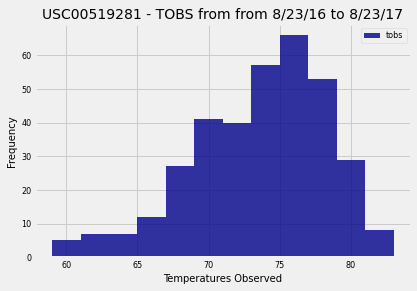

In [25]:
most_active_tobs_df = pd.DataFrame(most_active_tobs)
most_active_tobs_df.plot(kind="hist",bins=12, alpha=.8, color="darkblue")
plt.title("USC00519281 - TOBS from from 8/23/16 to 8/23/17", fontsize=14)
plt.xlabel("Temperatures Observed", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(["tobs"], fontsize=8)

tobs_graph = os.path.join('images','tobs.png')
plt.savefig(tobs_graph)


## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2016-11-23'
end_date = '2016-11-30'
temps = calc_temps(start_date, end_date)[0]
temps

(67.0, 74.08, 78.0)

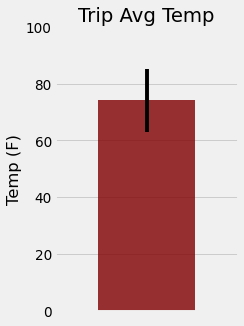

<Figure size 432x288 with 0 Axes>

In [47]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_pos = [0]
y_pos = [temps[1]]
error = [(temps[2] - temps[0])]

w = 3
h = 5
d = 70
plt.figure(figsize=(w, h), dpi=d)
plt.bar(x_pos,y_pos,color='maroon', yerr=error, alpha=0.8)
plt.xlim(-0.75,0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()
trip_avg_graph = os.path.join('images','trip_avg_temp.png')
plt.savefig(trip_avg_graph)


In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(station.station,  station.name, station.latitude, station.longitude, station.elevation).\
   filter(station.station == measurement.station).\
       filter(measurement.date >= start_date).filter(measurement.date <= end_date).\
           group_by(measurement.station).\
               order_by(measurement.prcp.desc()).all()


[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0)]

In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [43]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

from datetime import timedelta  

# Vacation Dates
start_date = dt.date(2016,11,23)
end_date = dt.date(2016,11,30) 

# Initialize variables for while loop
date_while = start_date 
vacation_dates = [date_while]

# Create a list with all the dates within the vacation range
while date_while < end_date:
    date_while += timedelta(days=1)
    vacation_dates.append(date_while)

# Calculate the normals in the list of vacation dates using the  %m-%d strings
normals = []
dates_normal = []
for date_for in vacation_dates:
    date_no_year = date_for.strftime('%m') + "-" + date_for.strftime('%d')
    normals.append(daily_normals(date_no_year)[0])
    dates_normal.append(date_no_year)

# Print the results
normals

[(64.0, 72.2, 80.0),
 (66.0, 72.56521739130434, 77.0),
 (63.0, 72.43181818181819, 78.0),
 (67.0, 73.51063829787235, 78.0),
 (63.0, 73.03921568627452, 78.0),
 (62.0, 72.75510204081633, 80.0),
 (62.0, 71.01960784313725, 79.0),
 (61.0, 71.8076923076923, 79.0)]

In [44]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, index=vacation_dates, columns = ['T Min' , 'T Avg', 'T Max']) 
normals_df.index.name = "Vacation Date"
normals_df

,T Min,T Avg,T Max
Vacation Date,,,
2016-11-23,64.0,72.200000,80.0
2016-11-24,66.0,72.565217,77.0
2016-11-25,63.0,72.431818,78.0
2016-11-26,67.0,73.510638,78.0
2016-11-27,63.0,73.039216,78.0
2016-11-28,62.0,72.755102,80.0
2016-11-29,62.0,71.019608,79.0
2016-11-30,61.0,71.807692,79.0


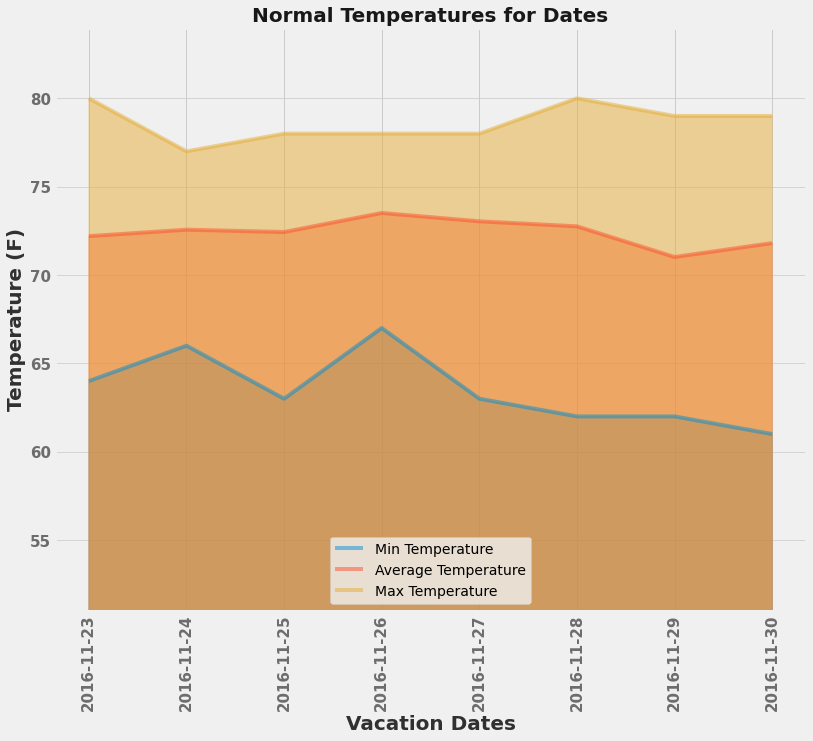

In [48]:
# Plot the daily normals as an area plot with `stacked=False`
# Plot the daily normals as an area plot with `stacked=False`

# Plot
normals_df.plot.area(stacked=False, figsize=(12, 10))

# Legend
plt.legend(('Min Temperature', 'Average Temperature', 'Max Temperature'),loc='lower center')

# Labeling, tickers and grids
plt.grid(axis='y', alpha=0.75);
plt.xlabel('Vacation Dates',fontweight="bold", alpha=0.8, fontsize=20);
plt.ylabel('Temperature (F)',fontweight="bold", alpha=0.8, fontsize=20);
plt.xticks(fontsize=15, fontweight="bold", alpha=0.55, rotation=90);
plt.yticks(fontsize=15, fontweight="bold", alpha=0.55);
plt.title('Normal Temperatures for Dates',
          fontweight="bold", alpha=0.9, fontsize=20);
plt.ylim(bottom=min(normals_df["T Min"])-10)  
# Save Plot
normal_temp_graph = os.path.join('images','normal_temp_graph.png')
plt.savefig(normal_temp_graph);

#Show the Plot
plt.show()

In [45]:
session.close()